# Laboratorio Ensembles

Jhoan Sebastian Medina Jimenez
## Utilizar árboles para detectar árboles 

Utilizaremos métodos de conjuntos basados en árboles en el conjunto de datos [Covertype](https://www.openml.org/d/180).
Contiene unas 100.000 observaciones de 7 tipos de árboles (abeto, pino, álamo, álamo temblón,...) descritos por 55 características que describen la elevación, la distancia al agua, el tipo de suelo, etc.

In [1]:

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
import seaborn as sns

In [2]:
# Download Covertype data. Takes a while the first time.
covertype = oml.datasets.get_dataset(180)
X, y, _, _ = covertype.get_data(target=covertype.default_target_attribute, dataset_format='array'); 
classes = covertype.retrieve_class_labels()
features = [f.name for i,f in covertype.features.items()][:-1]

Para entender los datos un poco mejor, podemos utilizar una matriz de dispersión. De ella se desprende que la altitud es una característica importante.
El abeto Douglas y el álamo temblón crecen a baja altitud, mientras que sólo los pinos de Krummholz sobreviven a altitudes muy elevadas.

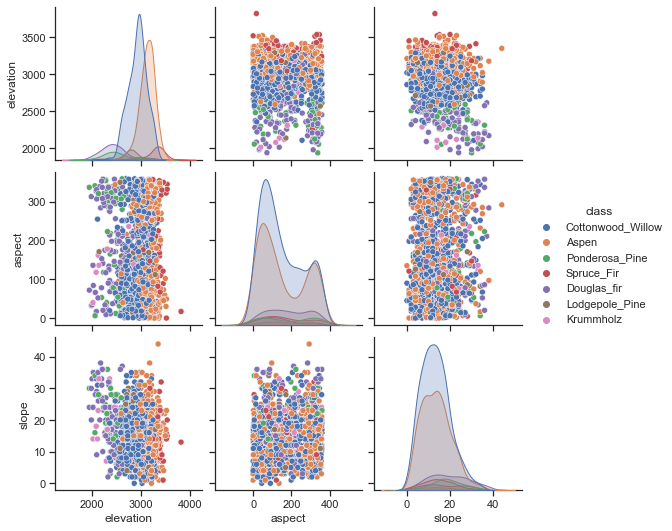

In [5]:
# Using seaborn to build the scatter matrix
# only first 3 columns, first 1000 examples
n_points = 1500
df = pd.DataFrame(X[:n_points,:3], columns=features[:3])
df['class'] = [classes[i] for i in y[:n_points]]
sns.set(style="ticks")
sns.pairplot(df, hue="class")

In [15]:
len(features)
DATA = pd.DataFrame(X)
DATA.columns = features
DATA["class"]  = y
DATA["class"] = DATA["class"].astype(str)



## Ejercicio 1: Bosques Aleatorios
Implemente una función `evaluate_RF` que mida el rendimiento de un clasificador Random Forest, utilizando árboles de (max) profundidad 2,8,32,64, para cualquier número de árboles en el conjunto (`n_estimators`). 
Para la evaluación debe medir la precisión utilizando la validación cruzada de 3 folds. 
Utilice `random_state=1` para garantizar la reproducibilidad. Por último, trace los resultados para al menos 5 valores de `n_estimators` que oscilen entre 1 y 30. Por supuesto, puede reutilizar el código de tareas anteriores. Interprete los resultados.
Puede tomar una submuestra del 50% para acelerar el trazado.



In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import make_scorer, precision_score



In [39]:

def evaluate_RF(df, n_estimators):


    X_train,X_test,y_train,y_test = train_test_split(df.drop(["class"], axis = 1 )
                                                 ,df["class"]
                                                 ,test_size=0.2, random_state=1)
    numericas = X_train.select_dtypes(include=[float, int]).columns.tolist()
    categoricas = X_train.select_dtypes(include=[object, 'category']).columns.tolist()

    # Varaibles numéricas
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="mean"))
               , ("scaler", StandardScaler())]
    )
    # Varaibles categóricas
    categorical_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="most_frequent"))
            , ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ]
    )
    # Pre procesador
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer,numericas),
            ("cat", categorical_transformer, categoricas),
        ]
    )
    
    scores_train_f=[]
    scores_test_f=[]
    scores_train_balanced=[]
    scores_test_balanced=[]
    max_depth = [2,8,32,64]

    for depht in max_depth:
        # Pipeline final
        pipeline = Pipeline([
        ('preprocesamiento', preprocessor),
        ('regresion',RandomForestClassifier(n_estimators = n_estimators,max_depth = depht, random_state=1))
        ])

        pipeline.fit(X_train,y_train)

        scores_train = np.mean(cross_val_score(pipeline, X_train, y_train, cv=3, scoring='accuracy'))
        scores_test = np.mean(cross_val_score(pipeline, X_train, y_train, cv=3, scoring='accuracy'))
        scores_train_f.append(scores_train)
        scores_test_f.append(scores_test)
        scores_train_ba = np.mean(cross_val_score(pipeline, X_train, y_train, cv=3, scoring='balanced_accuracy'))
        scores_test_ba = np.mean(cross_val_score(pipeline, X_train, y_train, cv=3, scoring='balanced_accuracy'))
        scores_train_balanced.append(scores_train_ba)
        scores_test_balanced.append(scores_test_ba)

    RESULTADOS = pd.DataFrame({
        "max_depth" :max_depth,
        "acc_train":scores_train_f,
        "acc_test":scores_test_f,
        "balanced_acc_train":scores_train_balanced,
        "balanced_acc_test":scores_test_balanced,

    })

    return RESULTADOS
    

In [41]:
RESULTADOS = []
for i in [1,5,10,15,20,25,30]:
    print(i)
    DF_RESULTS = evaluate_RF(DATA, i)
    DF_RESULTS['n_estimators'] = i
    RESULTADOS.append(DF_RESULTS)


1
5
10
15
20
25
30


In [47]:
DF_FINAL = pd.concat(RESULTADOS).reset_index()

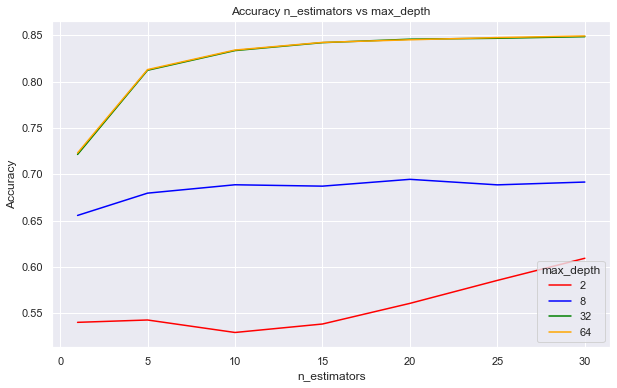

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=DF_FINAL, x="n_estimators", y="acc_test", hue="max_depth", palette = ["red", "blue", "green", "orange"])
plt.title("Accuracy n_estimators vs max_depth")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.show()

## Ejercicio 2: Otras medidas
Repita el mismo gráfico pero ahora utilice balanced_accuracy como medida de evaluación. Consulte la [documentación](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score).
Utilice sólo la profundidad máxima óptima de la pregunta anterior. ¿Ve alguna diferencia importante?

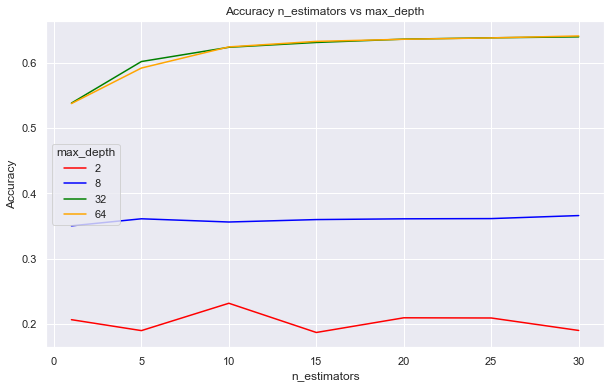

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=DF_FINAL, x="n_estimators", y="balanced_acc_test", hue="max_depth", palette = ["red", "blue", "green", "orange"])
plt.title("Accuracy n_estimators vs max_depth")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.show()

## Ejercicio 3: Importancia de las características
Obtenga la importancia de las características según el modelo de bosque aleatorio (ajustado). ¿Qué característica es la más importante?

El mejor modelo es el que tiene los siguientes parámetros
n_estimators = 30,max_depth = 64

In [56]:
X_train,X_test,y_train,y_test = train_test_split(DATA.drop(["class"], axis = 1 )
                                                 ,DATA["class"]
                                                 ,test_size=0.2, random_state=1)
numericas = X_train.select_dtypes(include=[float, int]).columns.tolist()
categoricas = X_train.select_dtypes(include=[object, 'category']).columns.tolist()

# Varaibles numéricas
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean"))
            , ("scaler", StandardScaler())]
)
# Varaibles categóricas
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent"))
        , ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
# Pre procesador
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer,numericas),
        ("cat", categorical_transformer, categoricas),
    ]
)


mejor_modelo  = Pipeline([
('preprocesamiento', preprocessor),
('regresion',RandomForestClassifier(n_estimators = 30,max_depth = 64))
])

mejor_modelo.fit(X_train,y_train)


Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['elevation', 'aspect',
                                                   'slope',
                                                   'horizontal_distance_to_hydrology',
                                                   'Vertical_Distance_To_Hydrology',
                                                   'Horizontal_Distance_To_Roadways',
                                                   'Hillshade_9am',
                                                   'Hillshade_Noon',
                                                 

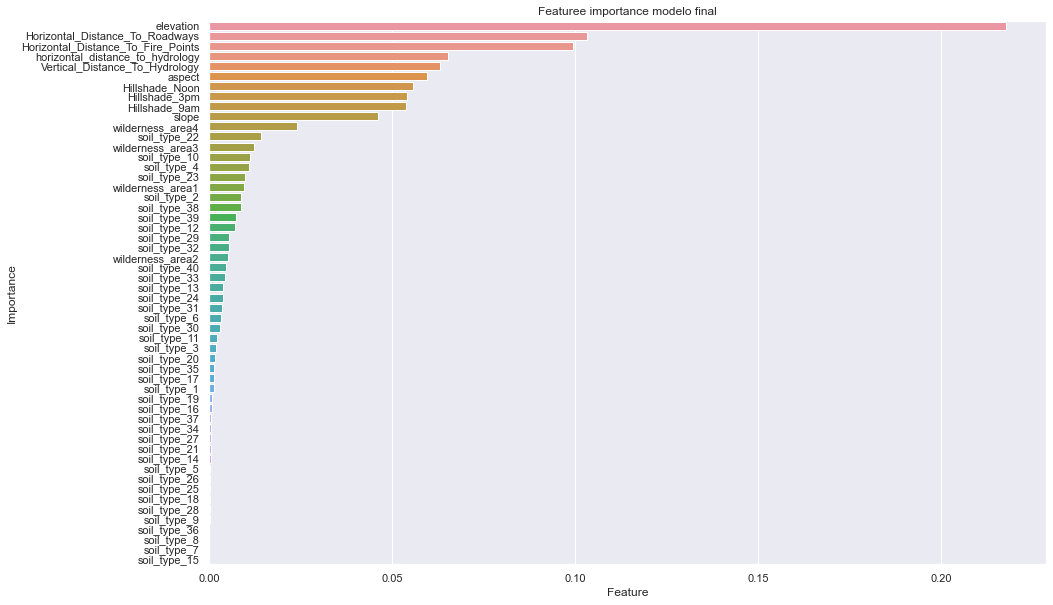

In [60]:
feature_importance = mejor_modelo.named_steps['regresion'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
sns.set_style("darkgrid")
plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Featuree importance modelo final")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

In [62]:
print("Balanced accuracy train")
print(np.mean(cross_val_score(mejor_modelo, X_train, y_train, cv=3, scoring='balanced_accuracy')))
print("Balanced accuracy test")
print(np.mean(cross_val_score(mejor_modelo, X_test, y_test, cv=3, scoring='balanced_accuracy')))

Balanced accuracy train
0.6390967992372693
Balanced accuracy test
0.6394495457525075


## Ejercicio 4: Selección de características
Vuelva a construir su bosque aleatorio afinado, pero esta vez utilizando sólo las 10 primeras características.
Devuelva tanto la precisión balanceada como el tiempo de entrenamiento. Interprete los resultados.

In [70]:
top_10 = list(feature_importance_df.head(10).Feature)


X_train_top_10 = X_train[top_10]
X_test_top_10 = X_test[top_10]

numericas_top_10 = X_train_top_10.select_dtypes(include=[float, int]).columns.tolist()
categoricas_top_10 = X_train_top_10.select_dtypes(include=[object, 'category']).columns.tolist()




In [73]:
# Varaibles numéricas
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean"))
            , ("scaler", StandardScaler())]
)
# Varaibles categóricas
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent"))
        , ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
# Pre procesador
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer,numericas_top_10),
        ("cat", categorical_transformer, categoricas_top_10),
    ]
)


mejor_modelo_top_10  = Pipeline([
('preprocesamiento', preprocessor),
('regresion',RandomForestClassifier(n_estimators = 30,max_depth = 64))
])

mejor_modelo_top_10.fit(X_train_top_10,y_train)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['elevation',
                                                   'Horizontal_Distance_To_Roadways',
                                                   'Horizontal_Distance_To_Fire_Points',
                                                   'horizontal_distance_to_hydrology',
                                                   'Vertical_Distance_To_Hydrology',
                                                   'aspect', 'Hillshade_Noon',
                                                   'Hillshade_3pm',
                    

In [75]:
print("Balanced accuracy train")
print(np.mean(cross_val_score(mejor_modelo_top_10, X_train_top_10, y_train, cv=3, scoring='balanced_accuracy')))
print("Balanced accuracy test")
print(np.mean(cross_val_score(mejor_modelo_top_10, X_test_top_10, y_test, cv=3, scoring='balanced_accuracy')))

Balanced accuracy train
0.6115262628135261
Balanced accuracy test
0.5073369130627857


El balanced accuracy de los modelos baja levemente cuando se tienen menos features así que se pueden tomar más de 10 

## Ejercicio 5: Matriz de confusión
Haga una retención estratificada estándar (standard stratified holdout) y genere la matriz de confusión del bosque aleatorio sintonizado. ¿Qué clases siguen confundiéndose a menudo?



In [77]:
X_train,X_test,y_train,y_test = train_test_split(DATA.drop(["class"], axis = 1 )
                                                 ,DATA["class"]
                                                 ,test_size=0.2, random_state=1, stratify = DATA["class"])
numericas = X_train.select_dtypes(include=[float, int]).columns.tolist()
categoricas = X_train.select_dtypes(include=[object, 'category']).columns.tolist()

# Varaibles numéricas
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean"))
            , ("scaler", StandardScaler())]
)
# Varaibles categóricas
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent"))
        , ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
# Pre procesador
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer,numericas),
        ("cat", categorical_transformer, categoricas),
    ]
)


mejor_modelo  = Pipeline([
('preprocesamiento', preprocessor),
('regresion',RandomForestClassifier(n_estimators = 30,max_depth = 64))
])

mejor_modelo.fit(X_train,y_train)


Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['elevation', 'aspect',
                                                   'slope',
                                                   'horizontal_distance_to_hydrology',
                                                   'Vertical_Distance_To_Hydrology',
                                                   'Horizontal_Distance_To_Roadways',
                                                   'Hillshade_9am',
                                                   'Hillshade_Noon',
                                                 

In [78]:
from sklearn.metrics import confusion_matrix
y_pred = mejor_modelo.predict(X_test)
cm = confusion_matrix(y_test, y_pred)


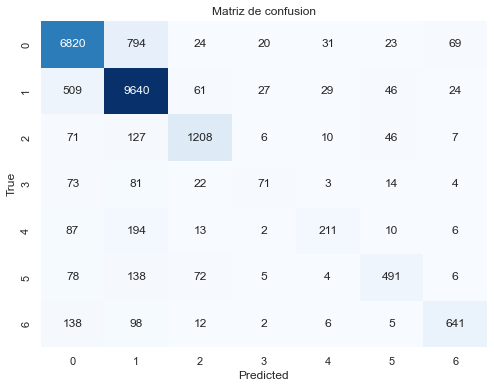

In [82]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Matriz de confusion")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

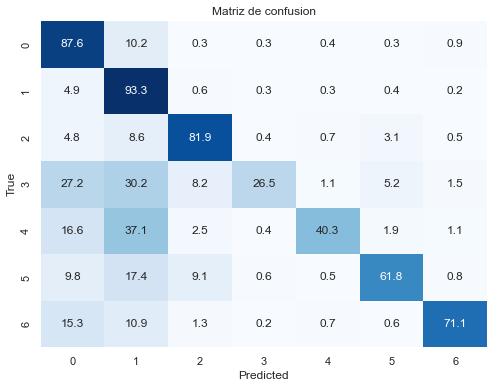

In [83]:
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, cmap="Blues", fmt=".1f", cbar=False)
plt.title("Matriz de confusion")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Se acomula la mala predicción en la clase 0 y en la 1, es allí donde el modelo tiende a confundirse

## Ejercicio 6: Un modelo de segundo nivel
Construya un modelo binario específico para elegir correctamente entre la primera y la segunda clase.
Seleccione sólo las observaciones con esas clases y entrene un nuevo bosque aleatorio. Haga una división estratificada estándar y trace la curva ROC resultante. ¿Podemos mejorar el modelo calibrando el umbral?

In [85]:
DATA_BINARIA = DATA[DATA["class"].isin(["0","1"])]
DATA_BINARIA

,elevation,aspect,slope,horizontal_distance_to_hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,soil_type_32,soil_type_33,soil_type_34,soil_type_35,soil_type_36,soil_type_37,soil_type_38,soil_type_39,soil_type_40,class
0,2754.0,146.0,5.0,150.0,2.0,1790.0,227.0,239.0,146.0,700.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,3219.0,21.0,8.0,67.0,-1.0,2869.0,215.0,223.0,145.0,1825.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2965.0,337.0,16.0,42.0,7.0,4288.0,184.0,217.0,171.0,324.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,3106.0,267.0,5.0,42.0,1.0,3716.0,207.0,242.0,173.0,1027.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,2568.0,90.0,4.0,212.0,23.0,470.0,226.0,233.0,141.0,1290.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109829,2585.0,36.0,11.0,192.0,62.0,1318.0,219.0,216.0,131.0,577.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
109830,2605.0,88.0,14.0,0.0,0.0,1487.0,240.0,216.0,103.0,272.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
109831,2600.0,288.0,1.0,182.0,80.0,1146.0,216.0,238.0,159.0,636.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
109832,2591.0,58.0,15.0,190.0,55.0,2644.0,230.0,207.0,107.0,706.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [91]:
def evaluate_RF(df, n_estimators):


    X_train,X_test,y_train,y_test = train_test_split(df.drop(["class"], axis = 1 )
                                                 ,df["class"]
                                                 ,test_size=0.2, random_state=1, stratify = df["class"])
    numericas = X_train.select_dtypes(include=[float, int]).columns.tolist()
    categoricas = X_train.select_dtypes(include=[object, 'category']).columns.tolist()

    # Varaibles numéricas
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="mean"))
               , ("scaler", StandardScaler())]
    )
    # Varaibles categóricas
    categorical_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="most_frequent"))
            , ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ]
    )
    # Pre procesador
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer,numericas),
            ("cat", categorical_transformer, categoricas),
        ]
    )
    
    scores_train_f=[]
    scores_test_f=[]
    scores_train_balanced=[]
    scores_test_balanced=[]
    max_depth = [2,8,32,64]

    for depht in max_depth:
        # Pipeline final
        pipeline = Pipeline([
        ('preprocesamiento', preprocessor),
        ('regresion',RandomForestClassifier(n_estimators = n_estimators,max_depth = depht, random_state=1))
        ])

        pipeline.fit(X_train,y_train)

        scores_train = np.mean(cross_val_score(pipeline, X_train, y_train, cv=3, scoring='accuracy'))
        scores_test = np.mean(cross_val_score(pipeline, X_train, y_train, cv=3, scoring='accuracy'))
        scores_train_f.append(scores_train)
        scores_test_f.append(scores_test)
        scores_train_ba = np.mean(cross_val_score(pipeline, X_train, y_train, cv=3, scoring='balanced_accuracy'))
        scores_test_ba = np.mean(cross_val_score(pipeline, X_train, y_train, cv=3, scoring='balanced_accuracy'))
        scores_train_balanced.append(scores_train_ba)
        scores_test_balanced.append(scores_test_ba)

    RESULTADOS = pd.DataFrame({
        "max_depth" :max_depth,
        "acc_train":scores_train_f,
        "acc_test":scores_test_f,
        "balanced_acc_train":scores_train_balanced,
        "balanced_acc_test":scores_test_balanced,

    })

    return RESULTADOS
    

In [92]:
RESULTADOS_2 = []
for i in [1,5,10,15,20,25,30]:
    print(i)
    DF_RESULTS = evaluate_RF(DATA_BINARIA, i)
    DF_RESULTS['n_estimators'] = i
    RESULTADOS_2.append(DF_RESULTS)


1
5
10
15
20
25
30


In [93]:
DF_FINAL_2 = pd.concat(RESULTADOS_2).reset_index()

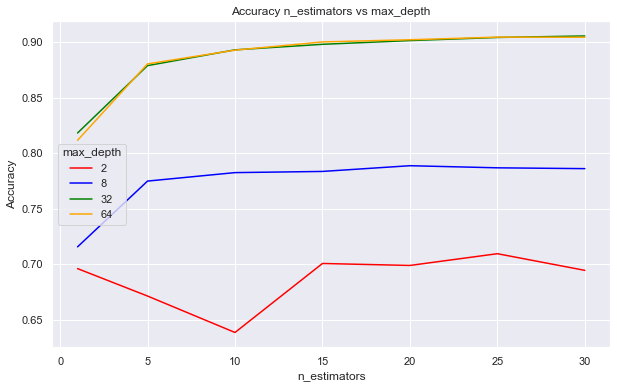

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=DF_FINAL_2, x="n_estimators", y="acc_test", hue="max_depth", palette = ["red", "blue", "green", "orange"])
plt.title("Accuracy n_estimators vs max_depth")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.show()

In [95]:
X_train,X_test,y_train,y_test = train_test_split(DATA_BINARIA.drop(["class"], axis = 1 )
                                                 ,DATA_BINARIA["class"]
                                                 ,test_size=0.2, random_state=1,stratify=DATA_BINARIA["class"])
numericas = X_train.select_dtypes(include=[float, int]).columns.tolist()
categoricas = X_train.select_dtypes(include=[object, 'category']).columns.tolist()

# Varaibles numéricas
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean"))
            , ("scaler", StandardScaler())]
)
# Varaibles categóricas
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent"))
        , ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
# Pre procesador
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer,numericas),
        ("cat", categorical_transformer, categoricas),
    ]
)


mejor_modelo  = Pipeline([
('preprocesamiento', preprocessor),
('regresion',RandomForestClassifier(n_estimators = 30,max_depth = 32, random_state=1))
])

mejor_modelo.fit(X_train,y_train)


Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['elevation', 'aspect',
                                                   'slope',
                                                   'horizontal_distance_to_hydrology',
                                                   'Vertical_Distance_To_Hydrology',
                                                   'Horizontal_Distance_To_Roadways',
                                                   'Hillshade_9am',
                                                   'Hillshade_Noon',
                                                 

In [96]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = mejor_modelo.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.9212385473010266


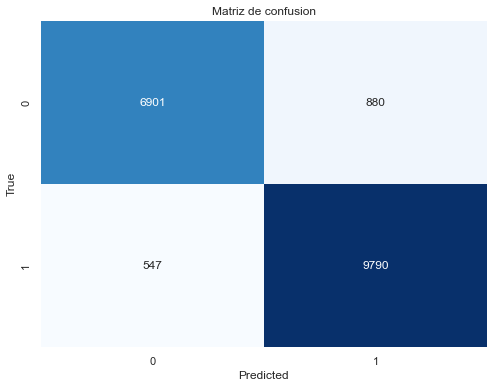

In [97]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Matriz de confusion")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

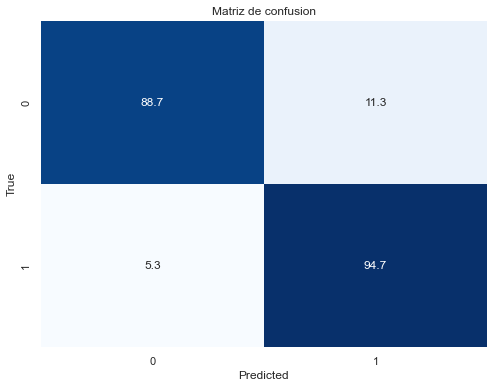

In [98]:
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, cmap="Blues", fmt=".1f", cbar=False)
plt.title("Matriz de confusion")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

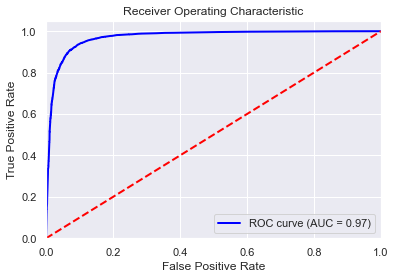

In [102]:
from sklearn.metrics import roc_curve, auc
y_test = y_test.astype(int)
y_pred = mejor_modelo.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

## Ejercicio 7
Implementa una función `evaluate_GB` que mida el rendimiento del `GradientBoostingClassifier` o del `XGBoostClassifier` para diferentes tasas de aprendizaje (0,01, 0,1, 1 y 10). Como antes, utilice una validación cruzada de 3 fold. Puede utilizar una muestra estratificada del 5% de todo el conjunto de datos.
Por último, trace los resultados para `n_estimadores` entre 1 y 100. Ejecute todos los GBClassifiers con `random_state=1` para garantizar la reproducibilidad.



Implemente una función que trace la puntuación de `evaluate_GB` para `n_estimators` = 10,20,30,...,100 en una escala lineal.

In [123]:
from xgboost import XGBClassifier
def evaluate_GB(df, n_estimators):
    df["class"] =  df["class"].astype(int)
    grouped = df.groupby('class')
    sampled_data = []

    for _, group_data in grouped:
        sample = group_data.sample(frac=0.05, random_state=1)
        sampled_data.append(sample)

    sampled_df = pd.concat(sampled_data)

    sampled_df = pd.concat(sampled_data)

    X_train,X_test,y_train,y_test = train_test_split(sampled_df.drop(["class"], axis = 1 )
                                                 ,sampled_df["class"]
                                                 ,test_size=0.2, random_state=1,stratify = sampled_df["class"])
                                                 
    numericas = X_train.select_dtypes(include=[float, int]).columns.tolist()
    categoricas = X_train.select_dtypes(include=[object, 'category']).columns.tolist()

    # Varaibles numéricas
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="mean"))
               , ("scaler", StandardScaler())]
    )
    # Varaibles categóricas
    categorical_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="most_frequent"))
            , ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ]
    )
    # Pre procesador
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer,numericas),
            ("cat", categorical_transformer, categoricas),
        ]
    )
    
    scores_train_f=[]
    scores_test_f=[]
    scores_train_balanced=[]
    scores_test_balanced=[]
    lrate = [0.01, 0.1, 1 , 10]

    for lr in lrate:
        # Pipeline final
        pipeline = Pipeline([
        ('preprocesamiento', preprocessor),
        ('regresion',XGBClassifier(n_estimators = n_estimators,learning_rate =lr, random_state=1))
        ])

        pipeline.fit(X_train,y_train)

        scores_train = np.mean(cross_val_score(pipeline, X_train, y_train, cv=3, scoring='accuracy'))
        scores_test = np.mean(cross_val_score(pipeline, X_train, y_train, cv=3, scoring='accuracy'))
        scores_train_f.append(scores_train)
        scores_test_f.append(scores_test)
        scores_train_ba = np.mean(cross_val_score(pipeline, X_train, y_train, cv=3, scoring='balanced_accuracy'))
        scores_test_ba = np.mean(cross_val_score(pipeline, X_train, y_train, cv=3, scoring='balanced_accuracy'))
        scores_train_balanced.append(scores_train_ba)
        scores_test_balanced.append(scores_test_ba)

    RESULTADOS = pd.DataFrame({
        "learning_rate" :lrate,
        "acc_train":scores_train_f,
        "acc_test":scores_test_f,
        "balanced_acc_train":scores_train_balanced,
        "balanced_acc_test":scores_test_balanced,

    })

    return RESULTADOS
    

In [124]:
RESULTADOS_2 = []
for i in np.arange(10,101,10):
    print(i)
    DF_RESULTS = evaluate_GB(DATA_BINARIA, i)
    DF_RESULTS['n_estimators'] = i
    RESULTADOS_2.append(DF_RESULTS)

DF_FINAL_2 = pd.concat(RESULTADOS_2).reset_index()

10


/var/folders/x_/66vmlwf952zchzc_3kyz6xy00000gp/T/ipykernel_20911/1635698230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["class"] =  df["class"].astype(int)


20


/var/folders/x_/66vmlwf952zchzc_3kyz6xy00000gp/T/ipykernel_20911/1635698230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["class"] =  df["class"].astype(int)


30


/var/folders/x_/66vmlwf952zchzc_3kyz6xy00000gp/T/ipykernel_20911/1635698230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["class"] =  df["class"].astype(int)


40


/var/folders/x_/66vmlwf952zchzc_3kyz6xy00000gp/T/ipykernel_20911/1635698230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["class"] =  df["class"].astype(int)


50


/var/folders/x_/66vmlwf952zchzc_3kyz6xy00000gp/T/ipykernel_20911/1635698230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["class"] =  df["class"].astype(int)


60


/var/folders/x_/66vmlwf952zchzc_3kyz6xy00000gp/T/ipykernel_20911/1635698230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["class"] =  df["class"].astype(int)


70


/var/folders/x_/66vmlwf952zchzc_3kyz6xy00000gp/T/ipykernel_20911/1635698230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["class"] =  df["class"].astype(int)


80


/var/folders/x_/66vmlwf952zchzc_3kyz6xy00000gp/T/ipykernel_20911/1635698230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["class"] =  df["class"].astype(int)


90


/var/folders/x_/66vmlwf952zchzc_3kyz6xy00000gp/T/ipykernel_20911/1635698230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["class"] =  df["class"].astype(int)


100


/var/folders/x_/66vmlwf952zchzc_3kyz6xy00000gp/T/ipykernel_20911/1635698230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["class"] =  df["class"].astype(int)


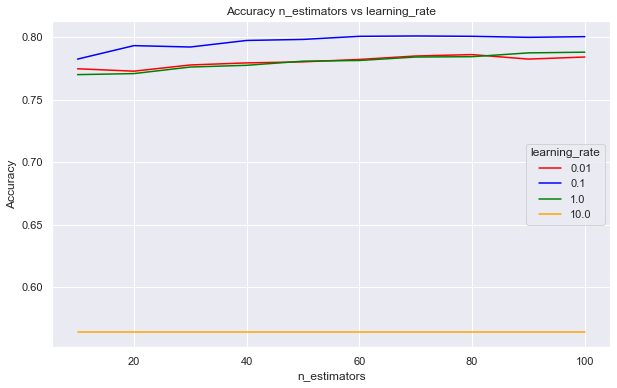

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=DF_FINAL_2, x="n_estimators", y="acc_test", hue="learning_rate", palette = ["red", "blue", "green", "orange"])
plt.title("Accuracy n_estimators vs learning_rate")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.show()